In [1]:
# Deep Learning with CNN architecture and MNIST Dataset

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.datasets import mnist
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from itertools import cycle

import tensorflow as tf
import time as time
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

In [3]:
class cnn_mnist(object):
    
         
    """

    A class to train a convolutional neural network with the 
    MNIST data set for image classification. 

    ...

    Methods
    -------
    init_tf():
        Lists the Tensorflow version along with all physical devices available (CPU and GPU).
    data_load():
        Loads the data, reshapes X_train/test to array with size: num_images, pix_x, pix_y, color_channel(s). 
        Normalization to bit depth of 2^8 is also applied. y_train/test are converted to categorical.
    init_model():
        The model architecture and methods for regularization as well as to prevent overfitting.
    train_model():
        Trains the model, depending on the available physical devices.
    eval_model():
        Evaluates the loss of missclassifications and the model's accuracy. Plots are included too.
    pred_model():
        Makes the predictions with y_test. Takes into account the wrongly classified images. Computes 
        precision, recall, accuracy and f1-score alongside the confusion matrix. 
        ROC curves are included too.
    save_model():
        Saves the model in .h5 format for further use. 

    """
            
    
    __slots__ = ['X_train', 'X_test', 'y_train', 'y_test',
                 'cnn', 'model', 'loss', 'accuracy', 'cm', 'pred_summary',
                 'predictions','images','incorrect_predictions']
    
    def __init__(self):
        pass
            
        
    def init_tf(self):
        print('\nTensorflow version:', tf.__version__)
        print('\nPhysical devices:\n', tf.config.list_physical_devices())
        print('\nNumber of GPUs available:', len(tf.config.experimental.list_physical_devices('GPU')))


    def data_load(self):

        (self.X_train, self.y_train), (self.X_test, self.y_test) = mnist.load_data()
        print('\nData successfully loaded.')

        self.X_train = self.X_train.reshape((60000, 28, 28, 1)) 
        self.X_train = self.X_train.astype('float32')/255
        self.y_train = to_categorical(self.y_train)
        self.X_test  = self.X_test.reshape((10000, 28, 28, 1))
        self.X_test  = self.X_test.astype('float32') / 255           
        self.y_test  = to_categorical(self.y_test)
        print('\nTrain data size:\n', self.X_train.shape)
        print('\nTrain target size:\n', self.y_train.shape)
        print('\nTest data size:\n', self.X_test.shape)
        print('\nTest target size:\n', self.y_test.shape)

    def init_model(self):
        self.cnn = Sequential()
        self.cnn.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', 
                     input_shape = (28, 28, 1), kernel_regularizer = 'l2'))
        self.cnn.add(tf.keras.layers.BatchNormalization())
        self.cnn.add(tf.keras.layers.Dropout(0.2))
        self.cnn.add(MaxPooling2D(pool_size = (2, 2)))
        self.cnn.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
        self.cnn.add(tf.keras.layers.BatchNormalization())
        self.cnn.add(tf.keras.layers.Dropout(0.2))
        self.cnn.add(MaxPooling2D(pool_size = (2, 2)))
        self.cnn.add(Flatten())
        self.cnn.add(Dense(units = 128, activation = 'relu'))
        self.cnn.add(tf.keras.layers.BatchNormalization())
        self.cnn.add(tf.keras.layers.Dropout(0.2))
        self.cnn.add(Dense(units = 10, activation = 'softmax'))
        self.cnn.compile(optimizer = 'adam',
                         loss = 'categorical_crossentropy',
                         metrics = ['accuracy'])
        self.cnn.summary()

    def train_model(self):

        start = time.time()

        try:
            print('\nTraining on the available GPU ...\n')
            with tf.device('/GPU:0'):
                 self.model = self.cnn.fit(self.X_train, 
                                           self.y_train, 
                                           epochs = 10, batch_size = 32, validation_split = 0.1)   
        except:
            print('\nFailed to train on the GPU. Training on the CPU instead ...\n')
            with tf.device('/CPU:0'):
                 self.model = self.cnn.fit(self.X_train, 
                                           self.y_train, 
                                           epochs = 10, batch_size = 32, validation_split = 0.1)


        end = time.time()
        total_time = end - start
        print("\n Training time elapsed in [s] = " + str(f'{total_time:.2f}'))

    def eval_model(self): 
        print('\nModel history keys:\n', self.model.history.keys())

        fig, ax = plt.subplots()
        plt.plot(self.model.history['loss'], linewidth = 3.5)
        plt.plot(self.model.history['val_loss'], linewidth = 3.5)
        plt.title('Model loss', size = 15, fontweight = 'bold')
        ax.spines[:].set_linewidth(3.5)
        plt.ylabel('Loss', size = 15, fontweight = 'bold')
        plt.yticks(fontsize = 15,fontweight = 'bold')
        plt.xlabel('Epoch', size = 15, fontweight = 'bold')
        plt.xticks(fontsize = 15,fontweight = 'bold')
        plt.legend(['Train', 'Validation'], loc = 'upper right', fontsize = 15)
        plt.show()

        fig, ax = plt.subplots()
        plt.plot(self.model.history['accuracy'], linewidth = 3.5)
        plt.plot(self.model.history['val_accuracy'], linewidth = 3.5)
        plt.title('Model accuracy', size = 15, fontweight = 'bold')
        ax.spines[:].set_linewidth(3.5)
        plt.ylabel('Accuracy', size = 15, fontweight = 'bold')
        plt.yticks(fontsize = 15,fontweight = 'bold')
        plt.xlabel('Epoch', size = 15, fontweight = 'bold')
        plt.xticks(fontsize = 15,fontweight = 'bold')
        leg = plt.legend(['Train', 'Validation'], loc='lower right', fontsize=15)
        plt.show()

        self.loss, self.accuracy = self.cnn.evaluate(self.X_test, self.y_test)
        print('\nModel loss:', f'{self.loss:.2f}')
        print('\nModel accuracy:', f'{self.accuracy:.2f}')

    def pred_model(self):     
        self.predictions = self.cnn.predict(self.X_test)
        self.images = self.X_test.reshape((10000, 28, 28))
        self.incorrect_predictions = []

        for i, (p, e) in enumerate(zip(self.predictions, self.y_test)):

            predicted, expected = np.argmax(p), np.argmax(e)

            if predicted != expected:
                self.incorrect_predictions.append((i, self.images[i], predicted, expected)) 

        print('\n All incorrect predictions:', len(self.incorrect_predictions))

        self.pred_summary = classification_report(np.argmax(self.y_test, axis = 1), 
                                                  np.argmax(self.predictions, axis = 1))
        print('Prediction summary:\n', self.pred_summary)

        self.cm = confusion_matrix(np.argmax(self.y_test, axis = 1), 
                                   np.argmax(self.predictions, axis = 1))
        print('The confusion matrix:\n', self.cm)


        n_classes = self.y_test.shape[1]
        lw = 2
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):

            fpr[i], tpr[i], _ = roc_curve(self.y_test[:, i], self.predictions[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(self.y_test.ravel(), self.predictions.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)

        for i in range(n_classes):

            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.figure()
        plt.plot(
            fpr["micro"],
            tpr["micro"],
            label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
            color="deeppink",
            linestyle=":",
            linewidth=4,
        )

        plt.plot(
            fpr["macro"],
            tpr["macro"],
            label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
            color="navy",
            linestyle=":",
            linewidth=4,
        )

        colors = cycle(["aqua", "darkorange", "cornflowerblue"])

        for i, color in zip(range(n_classes), colors):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
            )

        plt.plot([0, 1], [0, 1], "k--", lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC")
        #plt.legend(loc = "lower right")
        plt.show()

    def save_model(self): 
        self.cnn.save('mnist_cnn.h5')     

In [4]:
help(cnn_mnist())

Help on cnn_mnist in module __main__ object:

class cnn_mnist(builtins.object)
 |  A class to train a convolutional neural network with the 
 |  MNIST data set for image classification. 
 |  
 |  ...
 |  
 |  Methods
 |  -------
 |  init_tf():
 |      Lists the Tensorflow version along with all physical devices available (CPU and GPU).
 |  data_load():
 |      Loads the data, reshapes X_train/test to array with size: num_images, pix_x, pix_y, color_channel(s). 
 |      Normalization to bit depth of 2^8 is also applied. y_train/test are converted to categorical.
 |  init_model():
 |      The model architecture and methods for regularization as well as to prevent overfitting.
 |  train_model():
 |      Trains the model, depending on the available physical devices.
 |  eval_model():
 |      Evaluates the loss of missclassifications and the model's accuracy. Plots are included too.
 |  pred_model():
 |      Makes the predictions with y_test. Takes into account the wrongly classified images

In [5]:
dl = cnn_mnist()

In [6]:
dl.init_tf()


Tensorflow version: 2.9.2

Physical devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Number of GPUs available: 1


In [7]:
dl.data_load()


Data successfully loaded.

Train data size:
 (60000, 28, 28, 1)

Train target size:
 (60000, 10)

Test data size:
 (10000, 28, 28, 1)

Test target size:
 (10000, 10)


In [8]:
dl.init_model()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 batch_normalization_1 (Ba

2023-12-29 14:28:23.811453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-29 14:28:23.811534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
dl.train_model()


Training on the available GPU ...

Epoch 1/10


2023-12-29 14:28:24.074042: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-29 14:28:24.381254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1688/1688 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9656

2023-12-29 14:28:57.339909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1688/1688 [==============================] - 35s 20ms/step - loss: 0.1273 - accuracy: 0.9656 - val_loss: 0.0584 - val_accuracy: 0.9845
Epoch 2/10
1688/1688 [==============================] - 34s 20ms/step - loss: 0.0627 - accuracy: 0.9830 - val_loss: 0.0740 - val_accuracy: 0.9805
Epoch 3/10
1688/1688 [==============================] - 34s 20ms/step - loss: 0.0510 - accuracy: 0.9859 - val_loss: 0.0505 - val_accuracy: 0.9865
Epoch 4/10
1688/1688 [==============================] - 34s 20ms/step - loss: 0.0423 - accuracy: 0.9879 - val_loss: 0.0472 - val_accuracy: 0.9895
Epoch 5/10
1688/1688 [==============================] - 34s 20ms/step - loss: 0.0385 - accuracy: 0.9893 - val_loss: 0.0782 - val_accuracy: 0.9822
Epoch 6/10
1688/1688 [==============================] - 34s 20ms/step - loss: 0.0320 - accuracy: 0.9916 - val_loss: 0.0393 - val_accuracy: 0.9900
Epoch 7/10
1688/1688 [==============================] - 34s 20ms/step - loss: 0.0310 - accuracy: 0.9914 - val_loss: 0.0581 - val_accura


Model history keys:
 dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


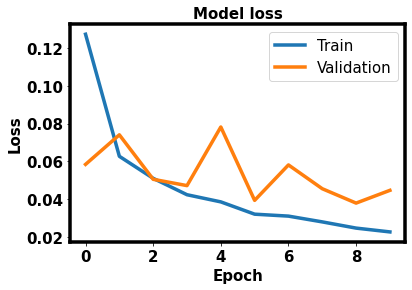

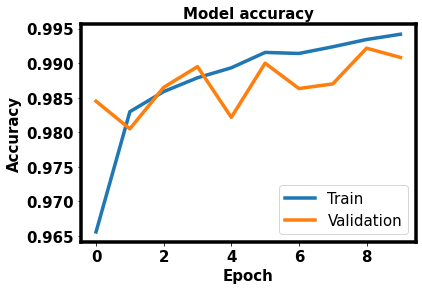

313/313 [==============================] - 3s 9ms/step - loss: 0.0431 - accuracy: 0.9897

Model loss: 0.04

Model accuracy: 0.99


In [10]:
dl.eval_model()

 33/313 [==>...........................] - ETA: 0s

2023-12-29 14:34:08.140220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step

 All incorrect predictions: 103
Prediction summary:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

The confusion matrix:
 [[ 978    1    0    0    0    0    0    1    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [ 

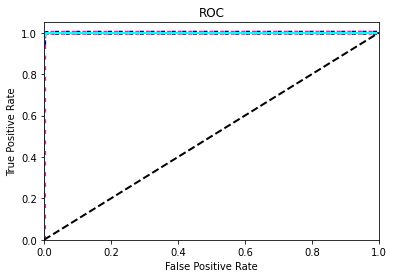

In [11]:
dl.pred_model()

In [12]:
dl.save_model()